In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
from torch.utils.data.dataset import Dataset
import os, sys, random
import numpy as np
import torchvision
from torchvision import transforms
import PIL
from PIL import Image
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [0]:
# extract labels from filenane- 0:Normal, 1:Abnormal 
def get_label(filename):
  return int(filename.split(".png")[0][-1])

In [0]:
# Segregating Normal and Abnormal cases

dataset_root = "/content/drive/My Drive/ChinaSet_Dataset/CXR_png/"
filelist = os.listdir(dataset_root)
filelist.sort()

pos_ex = []
neg_ex = []

for file in filelist:
  label = get_label(file)
  if(label == 0):
    pos_ex.append(file)
  else:
    neg_ex.append(file)


In [20]:
print("Total No. of examples in the dataset {}".format(len(filelist)))
print("No. of Normal cases {}".format(len(pos_ex)))
print("No. of Abnormal cases {}".format(len(neg_ex)))

Total No. of examples in the dataset 662
No. of Normal cases 326
No. of Abnormal cases 336


In [21]:
# Creating Test list
# we will use 90% data to train and remaining 10% to test
No_Test_ex = int(len(filelist)*0.1) # 66 samples for test

# we will use 33 Normal and Abnormal samples respectively for testing
# we could have randomly chosen 66 samples from the dataset but that would not 
# gaurantee sampling equal no. of positve and negative cases.
test_pos_list = random.sample(pos_ex,int(No_Test_ex/2))
test_neg_list = random.sample(neg_ex,int(No_Test_ex/2))

test_list = test_pos_list + test_neg_list
test_list.sort()
print("Total No. of test examples {}".format(len(test_list)))


# Creating Train list
train_list = []

for file in filelist:
  if(file not in test_list):
    train_list.append(file)
train_list.sort()    
print("Total No. of train examples {}".format(len(train_list)))

Total No. of test examples 66
Total No. of train examples 596


In [0]:
# creating trainlist.txt and testlist.txt

filetrain = open("/content/drive/My Drive/train_list.txt","w+")

for file in train_list:
  filetrain.write(file+"\n")
filetrain.close()

filetest = open("/content/drive/My Drive/test_list.txt","w+")

for file in test_list:
  filetest.write(file+"\n")
filetest.close()

In [0]:
img_size = 128

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

In [0]:
def default_list_reader(filelist):
  imglist = []
  with open(filelist,'r') as file:
    for line in file.readlines():
      imgname,_ = line.split("\n")
      imglist.append(imgname)
  imglist.sort()
  return imglist

In [0]:
class My_Dataset(Dataset):
  def __init__(self, root_dir, filelist = " ", transform = transforms.ToTensor(), list_reader = default_list_reader):
    self.root_dir = root_dir
    self.img_names = list_reader(filelist)
    self.labels = [get_label(img) for img in self.img_names]
    self.transform = transform
    
  def __getitem__(self,index):
    img = Image.open(self.root_dir+self.img_names[index])
    img = self.transform(img)
    return img,self.labels[index]
  
  def __len__(self):
    return len(self.img_names)
    
    

In [0]:
dataset_root = "/content/drive/My Drive/ChinaSet_Dataset/CXR_png/"
train_list_path = "/content/drive/My Drive/train_list.txt"
test_list_path = "/content/drive/My Drive/test_list.txt"

train_set = My_Dataset(root_dir=dataset_root, filelist = train_list_path, transform = train_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=8, shuffle=True)

test_set = My_Dataset(root_dir=dataset_root, filelist = test_list_path, transform = test_transform)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=8, shuffle=False)

In [0]:
class net(torch.nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.C1 = torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1, stride=1)
        self.model_ft = torchvision.models.resnet18(pretrained=True)
        self.model_ft.avgpool = torch.nn.AvgPool2d(kernel_size=4, padding=0, stride=2)
        self.model_ft.fc = torch.nn.Sequential(
            torch.nn.Linear(512,256),
            torch.nn.Linear(256,2)
        )
        
    def forward(self, x):
        y = self.C1(x)
        for _, layer in enumerate(list(self.model_ft.children())[:9]):
            y = layer(y)
        y = y.squeeze(-1).squeeze(-1)
        y = list(self.model_ft.children())[-1](y)
        return y

In [0]:
n_epochs = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Model = net().to(device)

optimizer = torch.optim.Adam(Model.parameters(), lr=6e-4, weight_decay=1e-2)
exp_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
criterion = torch.nn.CrossEntropyLoss()


In [29]:
Model

net(
  (C1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (model_ft): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): Batc

In [0]:
train_loss_track = []
test_loss_track = []

In [31]:
for eph in range(n_epochs):
    print('epoch : {} ...'.format(eph))
    n_correct = 0
    avg_loss = 0
    n_samples = 0
    Model.train()
    exp_lr_scheduler.step()
    for idx, xy in enumerate(train_loader):
        x, y = xy
        x, y = x.to(device), y.to(device)
        outputs = Model(x)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        n_correct += torch.sum(preds.data == y.data)
        avg_loss += loss.item()
        n_samples += x.size(0)
    avg_loss = avg_loss/n_samples
    train_loss_track.append(avg_loss)
    print('train avg loss : ', avg_loss)
    print('num of correct samples : {}/{}'.format(n_correct, n_samples))
    
    n_correct = 0
    avg_loss = 0
    n_samples = 0
    gt_labels = []
    pred_labels = []
    Model.eval()
    for idx, xy in enumerate(test_loader):
        x, y = xy
        x, y = x.cuda(), y.cuda()
        outputs = Model(x)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, y)
        
        n_correct += torch.sum(preds.data == y.data)
        gt_labels += list(y.data.cpu().numpy())
        pred_labels += list(preds.data.cpu().numpy())
        avg_loss += loss.item()
        n_samples += x.size(0)
    avg_loss = avg_loss/n_samples
    test_loss_track.append(avg_loss)
    print('test avg loss : ', avg_loss)
    print('num of correct samples : {}/{}'.format(n_correct, n_samples))

epoch : 0 ...
train avg loss :  0.07989015097686109
num of correct samples : 421/596
test avg loss :  0.10642124836643536
num of correct samples : 50/66
epoch : 1 ...
train avg loss :  0.06885337929597637
num of correct samples : 451/596
test avg loss :  0.09299044107848947
num of correct samples : 50/66
epoch : 2 ...
train avg loss :  0.06269629479654683
num of correct samples : 468/596
test avg loss :  0.07975184488477129
num of correct samples : 44/66
epoch : 3 ...
train avg loss :  0.058476873317220866
num of correct samples : 470/596
test avg loss :  0.09746974277676958
num of correct samples : 47/66
epoch : 4 ...
train avg loss :  0.05461362561823538
num of correct samples : 485/596
test avg loss :  0.14536728190653253
num of correct samples : 34/66
epoch : 5 ...
train avg loss :  0.05708697855772588
num of correct samples : 482/596
test avg loss :  0.08955457174416745
num of correct samples : 42/66
epoch : 6 ...
train avg loss :  0.05747786016772257
num of correct samples : 476/

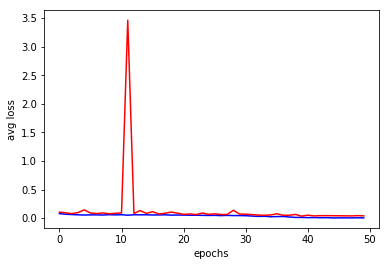

In [32]:
plt.plot(train_loss_track, 'b')
plt.plot(test_loss_track, 'r')
plt.xlabel('epochs')
plt.ylabel('avg loss')
plt.show()

In [33]:
target_names = ['No TB', 'TB']
print(classification_report(gt_labels, pred_labels, target_names=target_names))

              precision    recall  f1-score   support

       No TB       0.93      0.82      0.87        33
          TB       0.84      0.94      0.89        33

    accuracy                           0.88        66
   macro avg       0.88      0.88      0.88        66
weighted avg       0.88      0.88      0.88        66



In [0]:
model_save_name = 'model_res_pre.pt' 
path = F"/content/drive/My Drive/{model_save_name}" 
torch.save(Model.state_dict(), path)